Introduction to Image Processing - Segmenting Images
<html>
    <summary></summary>
         <div> <p></p> </div>
         <div style="font-size: 20px; width: 800px;"> 
              <h1>
               <left>Basic Image Manipulation in Python</left>
              </h1>
              <p><left>============================================================================</left> </p>
<pre>Course: BIOM 421, Spring 2024
Instructor: Brian Munsky
Authors: Dr. Zach Fox, Dr. Luis Aguilera, Brian Munsky
Contact Info: munsky@colostate.edu
</pre>
         </div>
    </p>

</html>

<details>
  <summary>Copyright info</summary>

```
Copyright 2024 Brian Munsky

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.

3. Neither the name of the copyright holder nor the names of its contributors may be used to endorse or promote products derived from this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
```
<details>



# Abstract

In this notebook, we will talk about single-cell segmentation and spot detection using Python. By now, we have covered basic image manipulation (see Module 4A and 4B). Here, our goal is introduce the basics of single-cell segmentation and particle detection.

## List of objectives

1. Understand and explain the more common methods used to segment cells from microscope images.
2. Understand and explain what a ***segmentation mask is***.
3. Understand and explain segmentation methods based on **threshold selection**.
4. Perform single-cell segmentation using **machine learning** based methods.
5. Understand the basics of **particle detection**.

![alt text](FigsA/Module_1_3/Slide2.png)

## Cell segmenation and spot detection (Summary):

1.   Thresholding
2.   Binarization
3.   Labeling



![alt text](FigsA/Module_1_2/Slide2.png)

<img src= https://github.com/MunskyGroup/uqbio2022/raw/master/files/files_image_processing/module_1_2/images/Slide3.png alt="drawing" width="1200"/>

![alt text](FigsA/Module_1_2/Slide4.png)

### Do it by hand
Using software such as [ImageJ/FIJI](https://imagej.nih.gov/ij/), [Napari](https://napari.org) or even something like Microsoft Paint, one can manually outline cells. This is cumbersome and impractical for processing thousands of cells over time.

![alt text](FigsA/Module_1_2/Slide5.png)

Check out this tool ([makesense](https://www.makesense.ai)) to create your own masks.

You can find some images in the following [link](https://www.dropbox.com/s/d9my4cp2j3ven04/test_data_uqbio2022.zip?dl=0)

# Getting started with segmentation using thresholding


### Watershed Methods
The scikit-image library has an excellent tutorial on [watershed methods](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_watershed.html). Popular tools that apply such methods to single cells are:
* [CellStar](http://cellstar-algorithm.org) (Matlab, Python, CellProfiler PlugIn)
* [FogBank](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-014-0431-x#additional-information) (Matlab)

![alt text](FigsA/Module_1_2/Slide6.png)

In [96]:
# Loading libraries
import random                        # Library to generate random numbers
import skimage                       # Library for image manipulation
import numpy as np                   # Library for array manipulation
import urllib.request                # Library to download data
import matplotlib.pyplot as plt      # Library used for plotting
from skimage import io, measure               # Module from skimage
from skimage.io import imread        # Module from skimage to read images as numpy arrays
from skimage.filters import gaussian # Module working with a gaussian filter
import pathlib                              # Library to work with file paths
import os
%matplotlib inline
from biom421 import codes
students = codes.spring2024Students()

from ipywidgets import interactive, HBox, VBox, Layout
import ipywidgets as widgets

from skimage.morphology import binary_dilation
from skimage.segmentation import watershed
from skimage.draw import polygon
from skimage.measure import regionprops
from skimage.color import label2rgb
from skimage.filters import threshold_otsu
from skimage.morphology import binary_erosion
from skimage.morphology import binary_closing
from skimage.morphology import binary_opening
from skimage.morphology import disk
from skimage.morphology import remove_small_objects
from scipy import ndimage as ndi              # Distance Transform
from skimage.feature import peak_local_max    # Local maxima in a matrix
from skimage.segmentation import watershed    # Watershed algorithm
from skimage.filters import difference_of_gaussians



Let's get started by downloading a sample image of a cell and plotting it using `matplotlib`:


In [2]:
# Downloading a test image
urls = ['https://ndownloader.figshare.com/files/26751209']
print('Downloading file...')
figName = './image_cell.tif'
urllib.request.urlretrieve(urls[0], figName)
# Loading figure to the notebook
images = imread(figName)
print('File is downloaded and accessible in: ... ./image_cell.tif ')


File is downloaded and accessible in: ... ./image_cell.tif 


In [3]:
# How do we find the figure we just saved?  I.e., what is figName = './image_cell.tif'   
# What is our current working directory (cwd)?    #import os #os.getcwd()
print(f'Our cvw is : {os.getcwd()}')

# What is the absolute path to the file?  #import os #os.path.abspath(figName)
print(f'The absolute path to the file is : {os.path.abspath(figName)}')


Our cvw is : /Users/munsky/Dropbox/Teaching_Projects/Course Materials/BIOM 4XX - Computational Anaalyses for BIOM/Codes/Repositories - Final/CourseMaterials/Module4-ImageProcessing
The absolute path to the file is : /Users/munsky/Dropbox/Teaching_Projects/Course Materials/BIOM 4XX - Computational Anaalyses for BIOM/Codes/Repositories - Final/CourseMaterials/Module4-ImageProcessing/image_cell.tif


In [4]:
# Printing the shape of the image
print('Original image shape: ' , images.shape)  # [T,Y,X,C]

# Selecting a frame and a color channel
img = images[0,:,:,0]
print('Single image shape: ' , img.shape)  # [Y,X]

Original image shape:  (35, 512, 512, 3)
Single image shape:  (512, 512)


In [5]:
# What is the difference  between images and img after the above code?
random.choice(students)

'Isabelle Lemma'

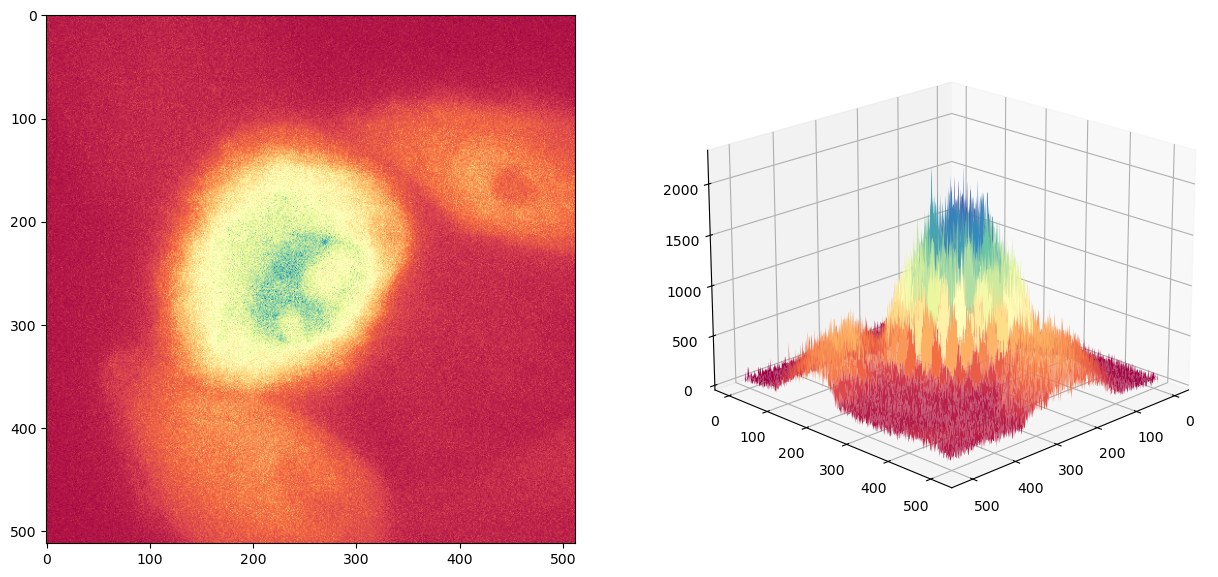

In [6]:
# Plotting the image as the 3d dimension figure.
space= np.arange(0, img.shape[0], 1)
xx, yy = np.meshgrid(space,space)
fig = plt.figure(figsize=(15,7))

# Set up the axes for the first plot
ax = fig.add_subplot(1, 2, 1)
ax.imshow(img,cmap='Spectral') # Reds_r

# Set up the axes for the second plot
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(xx, yy , img,  rstride=20, cstride=20, shade=False, cmap='Spectral')
ax2.view_init(20, 45)
plt.show()

Recall when we plotted the histogram of the intensity pixels to get a sense of the distribution of pixel intensities throughout the image. Let's do that again here.

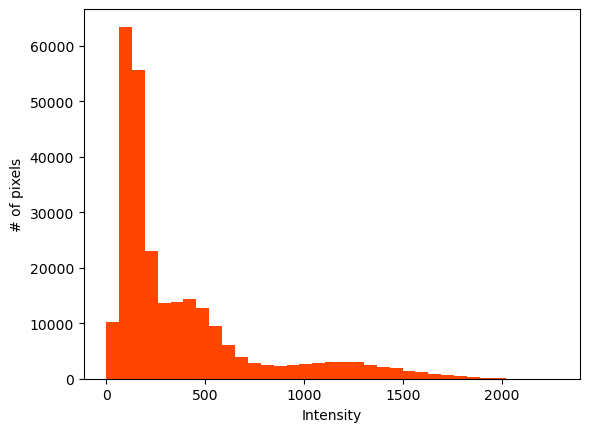

In [7]:
# Plotting the intensity distribution
f, ax = plt.subplots()
ax.hist(img.flatten(),color='orangered',bins=35)  # .ravel()
ax.set_xlabel('Intensity')
ax.set_ylabel('# of pixels')
plt.show()

In [8]:
# There are three peaks in the histogram. What do you think they represent?
random.choice(students)

'Alex David'

## Segmentaton based on threshold selection

Based on this image, we can guess a threshold of pixel intensities that are "cells" vs "not cells". What do you think would make a good threshold?

In [9]:
random.choice(students)

'Alex Cerullo'

In [10]:
# Thresholding the image
def viewer(threshold=50):
    mask_image = np.zeros(img.shape)
    mask_image[img>threshold] = 255
    f,ax = plt.subplots()
    ax.imshow(mask_image, cmap='Greys')
    plt.show()

interactive_plot = interactive(viewer,threshold = widgets.IntSlider(min=0,max=2000,step=1,value=0,description='threshold'))       
controls = HBox(interactive_plot.children[:-1], layout = Layout(flex_flow='row wrap'))
output = interactive_plot.children[-1]

# Display the controls and output as an interactive widget
display(VBox([controls, output]))    

This mask image is useful, especially considering we simply took all of the pixels with a value bigger than `threshold`.

However, we know that the outside ought to be more smooth. Let's try applying a Gaussian filter to smooth out the mask image:


In [11]:
# Thresholding the image
def viewer(threshold=50, sigma=5):
    mask_image = np.zeros(img.shape)
    mask_image[img>threshold] = 255
    new_mask = gaussian(mask_image, sigma=sigma)
    f,ax = plt.subplots(1,2, figsize=(10,5))
    ax[0].imshow(mask_image, cmap='Spectral')
    ax[1].imshow(new_mask, cmap='Spectral')
    plt.show()
    return new_mask

interactive_plot = interactive(viewer, \
            threshold = widgets.IntSlider(min=0,max=2000,step=1,value=0,description='threshold'),\
            sigma = widgets.IntSlider(min=0,max=10,step=1,value=0,description='sigma'))       

controls = HBox(interactive_plot.children[:-1], layout = Layout(flex_flow='row wrap'))
output = interactive_plot.children[-1]

# Display the controls and output as an interactive widget
display(VBox([controls, output]))    

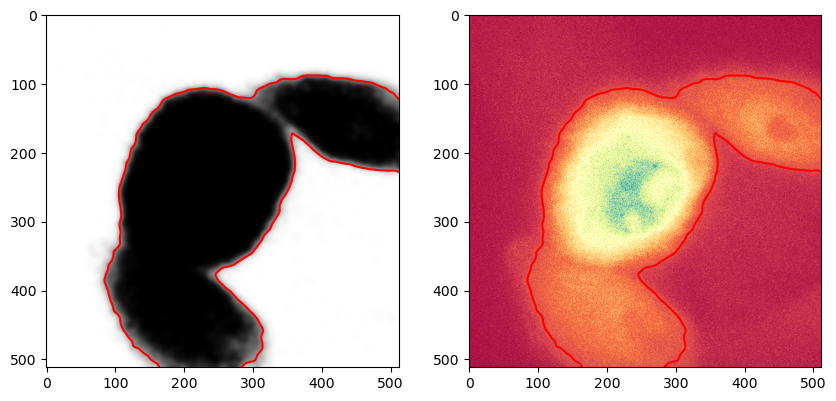

In [23]:
# Plotting all contours detected in the filtered image
new_mask = interactive_plot.result

f,ax = plt.subplots(1,2, figsize=(10,5))
contours = measure.find_contours(new_mask, level=125 ) # level is half of 255 (ish). What happens if we change it?
contours_connected = np.vstack((contours))
ax[0].imshow(new_mask, cmap='Greys')
ax[1].imshow(images[0,:,:,0], cmap='Spectral')
for contour in contours:
  ax[0].plot(contour[:,1],contour[:,0],color='r')  
  ax[1].plot(contour[:,1],contour[:,0],color='r')

In [16]:
# How would I learn how the function find_contours works?  
random.choice(students)

'Mark Metheny'

So far so good. By setting `threshold=700` we were able to find the "main" cell in the image. But what happens when we want to get all three? Try lowering the threshold to  300 and running the code.

_it looks like a crab_ !


In the cell below, we will try to take the connected image below and use a [watershed algorithm](https://en.wikipedia.org/wiki/Watershed_(image_processing) to break it into 3 distinct cells.

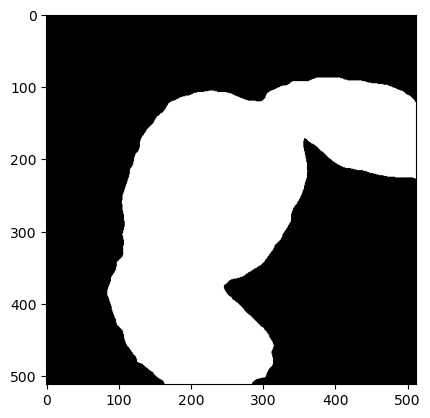

min value in mask:  0
max value in mask:  1


In [24]:
# make a new mask from the contours array
watershed_starting_mask = np.zeros(img.shape).astype(int)                    # Prealocating an array with zeros. Notice the datatype.
rr, cc = polygon(contours_connected[:,0], contours_connected[:,1])           # Returns the coordinates inside the contour
watershed_starting_mask[rr,cc] = 1                                           # Replacing all values inside the contour with ones.

# Plotting the mask
f,ax = plt.subplots()
ax.imshow(watershed_starting_mask, cmap='Greys_r')
plt.show()

# Printing the minimum and maximum values in the image
print('min value in mask: ', np.min(watershed_starting_mask) )
print('max value in mask: ', np.max(watershed_starting_mask) )

To find more information about the specific method use

```
help(watershed)
```



### Distance transform



"The distance transform computes the distance between each pixel and the nearest zero/nonzero pixel." An example with code implementation is accessible in this [link](https://www.youtube.com/watch?v=oxWfLTQoC5A).

For more infromation about the distance transform check this [link](https://homepages.inf.ed.ac.uk/rbf/HIPR2/distance.htm)

<img src= https://homepages.inf.ed.ac.uk/rbf/HIPR2/figs/distance.gif alt="drawing" width="600"/>



By  using the distance transform we can find basins in the center of each cell.

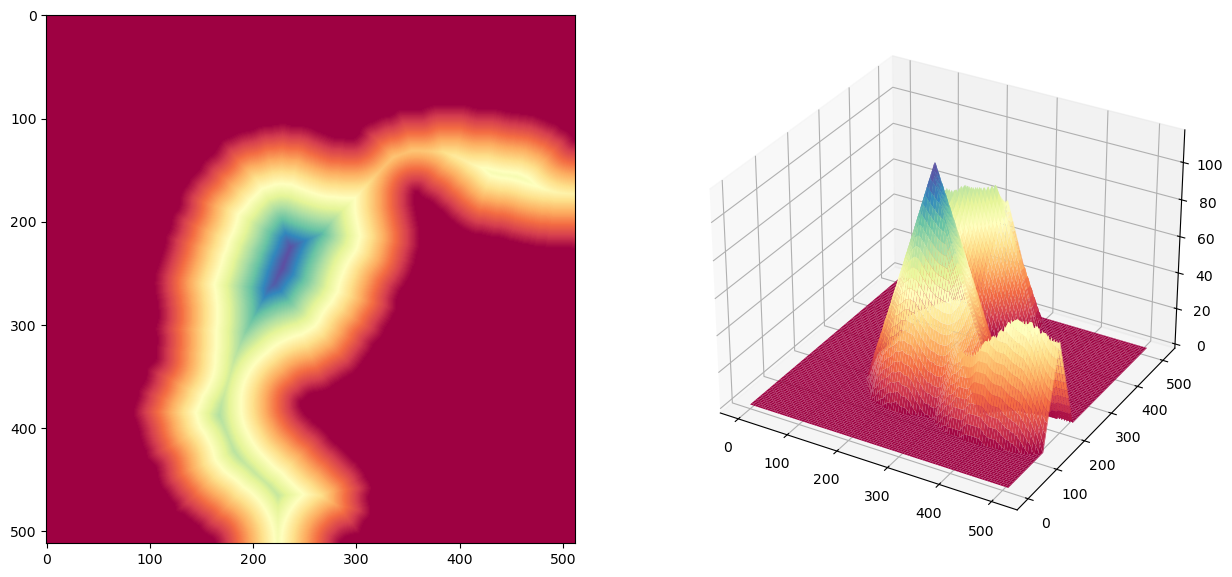

In [25]:
# Computes the Distance Transform distance in the image
distance = ndi.distance_transform_edt(watershed_starting_mask)

# Plotting the image as the 3d dimension figure.
space= np.arange(0, distance.shape[0], 1)
xx, yy = np.meshgrid(space,space)
fig = plt.figure(figsize=(15,7))
# Set up the axes for the first plot
ax = fig.add_subplot(1, 2, 1)
ax.imshow(distance,cmap='Spectral') # Reds_r
# Set up the axes for the second plot
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(xx, yy , distance,  rstride=5, cstride=5, shade=False, cmap='Spectral')
#ax2.view_init(30, 45)
plt.show()

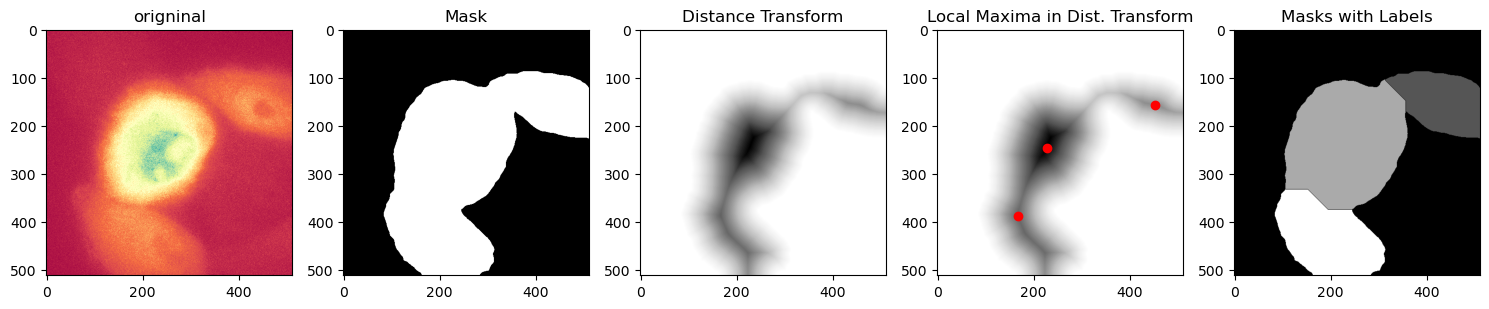

In [26]:
# Apply watershed
# Compute the Distance Transform distance in the image
distance = ndi.distance_transform_edt(watershed_starting_mask)                       # Computes the Distance Transform distance in the image

# Use the Distance transform image to find local maxima
coords = peak_local_max(distance, min_distance=50, labels=watershed_starting_mask)  

 # Selecting unique indexes
_,inds = np.unique(distance[coords[:,0],coords[:,1]],return_index=True)      # Make sure they are unique
coords = coords[inds,:]                                                     

# Create a mask associated with the local maxima
mask = np.zeros(distance.shape, dtype=bool)        # Prealocating an array with zeros
mask[tuple(coords.T)] = True                       # Make an image with 1's where local maxima are
markers, _ = ndi.label(mask)                       # Unique values used as the desired labels

# Using the watershed algorithm
labels = watershed(-distance, markers, mask=watershed_starting_mask, watershed_line=True)  
#Why do we need to use the negative of the distance matrix?

# Plot the results
f,ax = plt.subplots(1,5, figsize=(15,7))
ax[0].imshow(img, cmap='Spectral')
ax[0].set_title('origninal')
ax[1].imshow(watershed_starting_mask, cmap='Greys_r')
ax[1].set_title('Mask')
ax[2].imshow(ndi.distance_transform_edt(watershed_starting_mask), cmap='Greys')
ax[2].set_title('Distance Transform')
ax[3].imshow(ndi.distance_transform_edt(watershed_starting_mask), cmap='Greys')
ax[3].scatter(coords[:,1],coords[:,0],c='r')
ax[3].set_title('Local Maxima in Dist. Transform')
ax[4].imshow(labels, cmap='gray') #Spectral
ax[4].set_title('Masks with Labels')
f.tight_layout()

# The concept of **Masks** and labels

The shape of our image is (35, 512, 512, 3)
The shape of our labels is (512, 512)


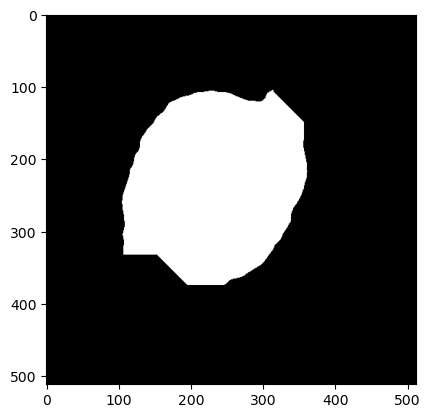

In [27]:
# How would I show an image of just the first cell?
# Remember,
print(f'The shape of our image is {images.shape}')
print(f'The shape of our labels is {labels.shape}')
random.choice(students)

# How should I change this?
plt.imshow((labels==2), cmap='gray')

# Machine Learning Methods






In recent years, deep learning methods have rapidly improved the state of the art for cell segmentation methods. We will come back to the theory on this topic - for now, we will demonstrate a couple of ML-based tools that can be used to segment images. If you are keen to get started learning about how the popular U-Net model works, check out [this video](https://www.youtube.com/watch?v=azM57JuQpQI) and/or [this video](https://www.youtube.com/watch?v=4ZZjr6SFBV8).



## Cellpose

The [CellPose](https://www.nature.com/articles/s41592-020-01018-x) algorithm uses a [U-Net approach](https://arxiv.org/pdf/1505.04597.pdf), but is a generalist algorithm that can work with a wide variety of cell types.

![alt text](FigsA/Module_1_2/Slide8.png)

One of the biggest problems in single-cell segmentation is the limited number of images that are needed to traing a machine learning algorithm.

![alt text](FigsA/Module_1_2/Slide9.png)
![alt text](FigsA/Module_1_2/Slide10.png)
![alt text](FigsA/Module_1_2/Slide11.png)
![alt text](FigsA/Module_1_2/Slide12.png)


### Segmenting a complete cell using Cellpose

image shape:  (35, 512, 512, 3)


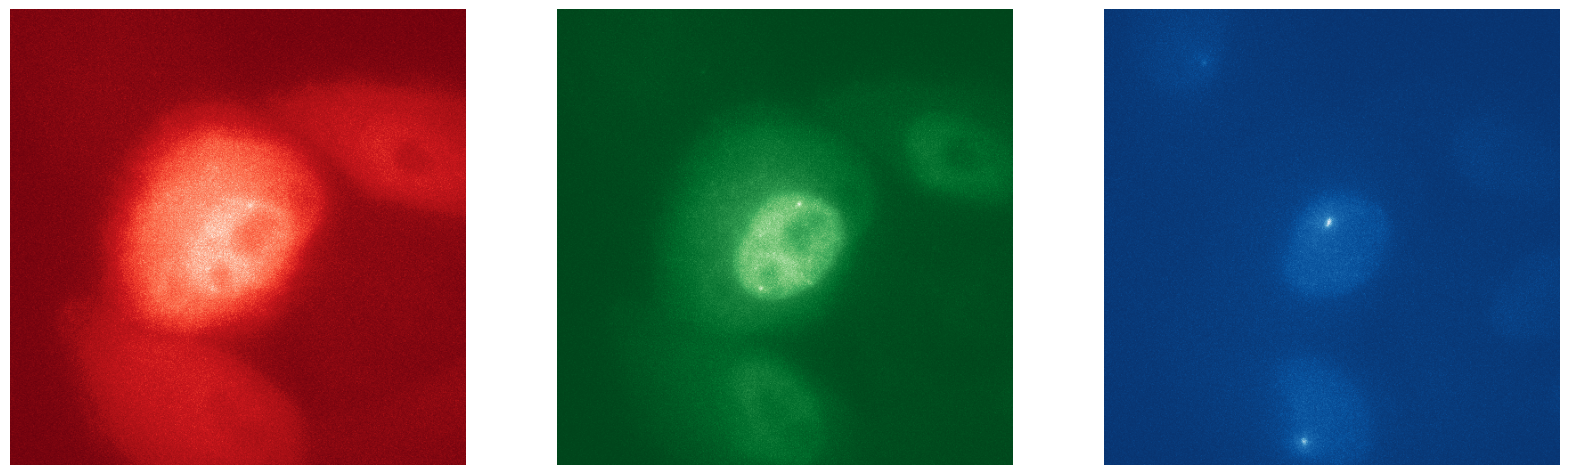

In [4]:
# Downloading test image

# Hela Cells. Linda's Publication.
urls = ['https://ndownloader.figshare.com/files/26751209']
urllib.request.urlretrieve(urls[0], './image_cell.tif')
figName = './image_cell.tif'
image_complete = imread(figName)

print('image shape: ', image_complete.shape)

# Plotting each one of the 3 colors independently
fig, ax = plt.subplots(1,3, figsize=(20, 7))
ax[0].imshow(image_complete[0,:,:,0],cmap='Reds_r')
ax[1].imshow(image_complete[0,:,:,1],cmap='Greens_r')
ax[2].imshow(image_complete[0,:,:,2],cmap='Blues_r')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
plt.show()

Installing cellpose

In [2]:
# %pip install --upgrade  cellpose
# os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'
# from cellpose import models
from cellpose import plot, models

In [5]:
img = image_complete[0,:,:,0]

100%|██████████| 25.3M/25.3M [00:03<00:00, 8.03MB/s]
100%|██████████| 5.23k/5.23k [00:00<00:00, 6.38MB/s]


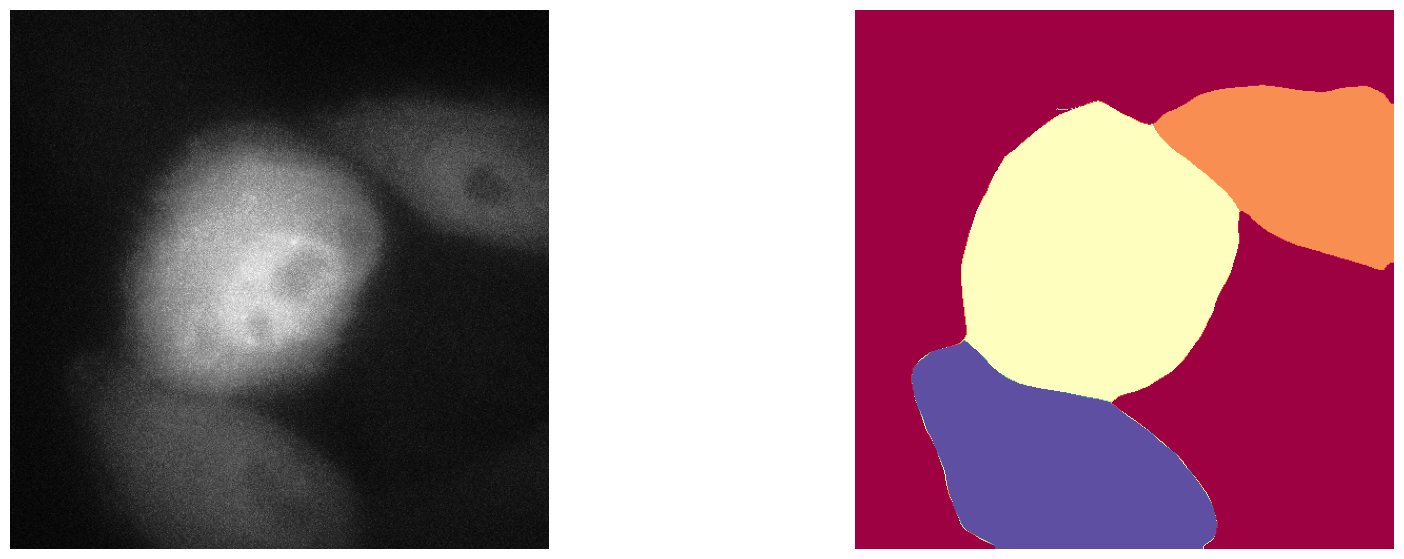

Values in mask:  [0 1 2 3 4]


In [6]:
# RUN CELLPOSE
model = models.Cellpose(model_type='cyto') # model_type='cyto' or model_type='nuclei'
masks  = model.eval(img, diameter=200)[0]
# Plotting each one of the 3 colors independently
fig, ax = plt.subplots(1,2, figsize=(20, 7))
ax[0].imshow(img,cmap='Greys_r')
ax[1].imshow(masks,cmap='Spectral')
ax[0].axis('off')
ax[1].axis('off')
plt.show()
print('Values in mask: ', np.unique (masks))

In [7]:
# Let's see what evaluation information we can get from our model
help(model.eval)

Help on method eval in module cellpose.models:

eval(x, batch_size=8, channels=[0, 0], channel_axis=None, invert=False, normalize=True, diameter=30.0, do_3D=False, **kwargs) method of cellpose.models.Cellpose instance
    Run cellpose size model and mask model and get masks.
    
    Args:
        x (list or array): List or array of images. Can be list of 2D/3D images, or array of 2D/3D images, or 4D image array.
        batch_size (int, optional): Number of 224x224 patches to run simultaneously on the GPU. Can make smaller or bigger depending on GPU memory usage. Defaults to 8.
        channels (list, optional): List of channels, either of length 2 or of length number of images by 2. First element of list is the channel to segment (0=grayscale, 1=red, 2=green, 3=blue). Second element of list is the optional nuclear channel (0=none, 1=red, 2=green, 3=blue). For instance, to segment grayscale images, input [0,0]. To segment images with cells in green and nuclei in blue, input [2,3]. To 

# Segmenting nuclei and cytosol

In [8]:
# Downloading Fluorescence In Situ Hybridization (FISH) data
# Downloading the image to Colab

urls = ['https://github.com/MunskyGroup/FISH_Processing/raw/main/dataBases/example_data/ROI002_XY1620755646_Z00_T0_merged.tif']
print('Downloading file...')
urllib.request.urlretrieve(urls[0], './ROI001_XY1620755243_Z00_T0_merged.tif')
figName = './ROI001_XY1620755243_Z00_T0_merged.tif'
images_FISH = imread(figName)

# The image has the following dimensions [Z,Y,X,C]
print('The image has the following dimensions [Z,Y,X,C]: ' ,images_FISH.shape)

# For segmentation, we will select the central  slice.
image_to_segment= images_FISH[10,:,:,:]


The image has the following dimensions [Z,Y,X,C]:  (23, 928, 624, 3)


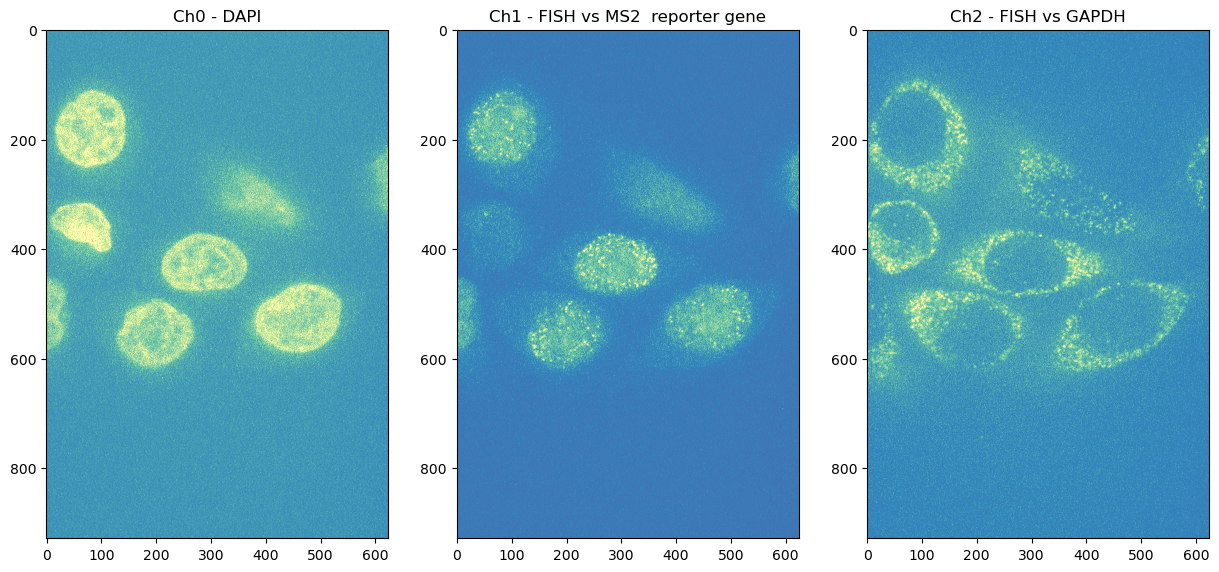

In [136]:
fig, ax = plt.subplots(1,3, figsize=(15, 8))
zSlice = 10
ax[0].imshow(images_FISH[zSlice,:,:,0],cmap='Spectral_r')
ax[0].set(title='Ch0 - DAPI')
ax[1].imshow(images_FISH[zSlice,:,:,1],cmap='Spectral_r')
ax[1].set(title= 'Ch1 - FISH vs MS2  reporter gene' )
ax[2].imshow(images_FISH[zSlice,:,:,2],cmap='Spectral_r')
ax[2].set(title= 'Ch2 - FISH vs GAPDH' )
plt.show()

In [11]:
model.eval?

Signature:
model.eval(
    x,
    batch_size=8,
    channels=[0, 0],
    channel_axis=None,
    invert=False,
    normalize=True,
    diameter=30.0,
    do_3D=False,
    **kwargs,
)
Docstring:
Run cellpose size model and mask model and get masks.

Args:
    x (list or array): List or array of images. Can be list of 2D/3D images, or array of 2D/3D images, or 4D image array.
    batch_size (int, optional): Number of 224x224 patches to run simultaneously on the GPU. Can make smaller or bigger depending on GPU memory usage. Defaults to 8.
    channels (list, optional): List of channels, either of length 2 or of length number of images by 2. First element of list is the channel to segment (0=grayscale, 1=red, 2=green, 3=blue). Second element of list is the optional nuclear channel (0=none, 1=red, 2=green, 3=blue). For instance, to segment grayscale images, input [0,0]. To segment images with cells in green and nuclei in blue, input [2,3]. To segment one grayscale image and one image with ce

(928, 624, 2)


number of detected cells:  8


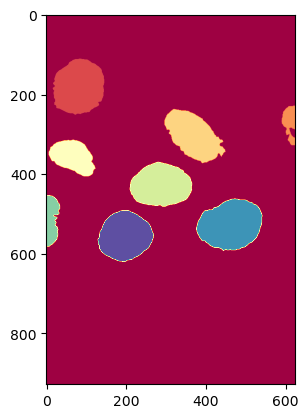

In [13]:
# Segmenting the nuclei
img_nuc = images_FISH[zSlice,:,:,0:2]
print(img_nuc.shape)
use_GPU = False  # Set to True if you have a GPU - this will make it MUCH faster.
model = models.Cellpose(gpu=use_GPU, model_type='nuclei') # model_type='cyto' or model_type='nuclei'
masks_nuc = model.eval(img_nuc, diameter=100, channels=[0,1])[0]
print('number of detected cells: ', np.max(masks_nuc))
plt.imshow(masks_nuc,cmap='Spectral')
plt.show()

(928, 624, 3)


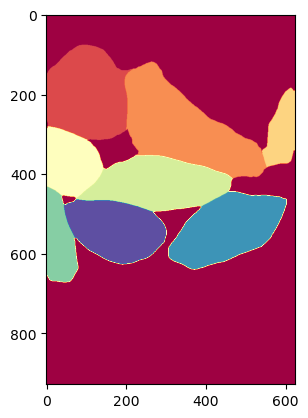

In [14]:
# Segmenting the cytosol
img_cyto = images_FISH[zSlice,:,:,0:3]
print(img_cyto.shape)
use_GPU = False
model = models.Cellpose(gpu=use_GPU, model_type='cyto2') # model_type='cyto', 'cyto2' or model_type='nuclei'
masks_cyto, flows, styles, diams = model.eval(img_cyto, diameter=200, channels=[0,2])
plt.imshow(masks_cyto,cmap='Spectral')
plt.show()

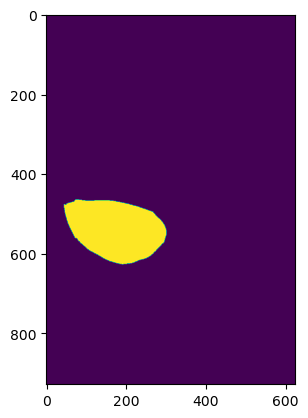

In [17]:
plt.imshow(masks_cyto==8)
plt.show()

### Calculating the area of each cell in the image

In [18]:
# How could we access just the pixels forming a specific cell and find the cell area?
random.choice(students)

'Alex David'

In [ ]:
# area = ???

In [47]:
# Associating each nucleus with its corresponding cytosol
nucleus_indices = np.zeros(np.max(masks_cyto)+1)
for i in range(1,np.max(masks_nuc)+1):
    posn_nucl = np.mean(np.where(masks_nuc==i),axis=1).astype(int)
    nucleus_indices[masks_cyto[posn_nucl[0],posn_nucl[1]]] = i

print(nucleus_indices)

[0. 1. 3. 2. 4. 5. 6. 7. 8.]


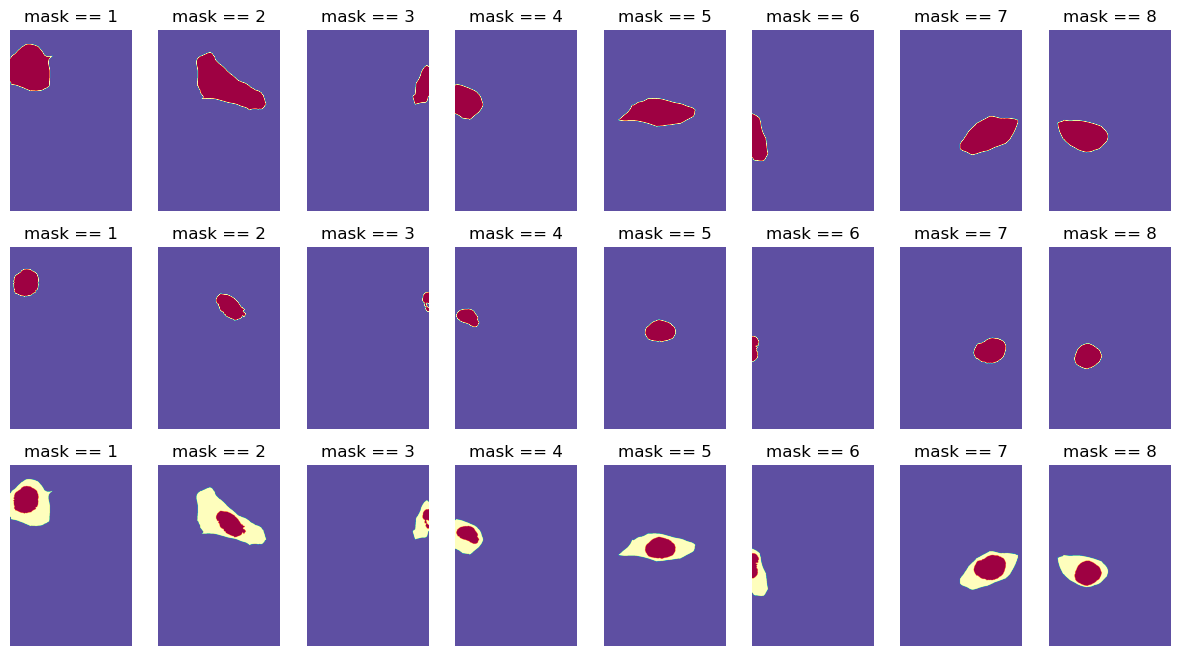

In [56]:
# Show the cytoplasms and corresponding nuclei
number_detected_cells = np.max(masks_cyto)

fig, ax = plt.subplots(3,number_detected_cells, figsize=(15, 8))
for i in range (1,number_detected_cells+1):
  selected_cyto_mask = masks_cyto==i
  ax[0,i-1].imshow(selected_cyto_mask,cmap='Spectral_r')
  ax[0,i-1].set(title='mask == ' + str(i) )
  ax[0,i-1].axis('off')

  # find which nucleus is associated with the cytosol
  selected_nuc_mask = masks_nuc==nucleus_indices[i]
  ax[1,i-1].imshow(selected_nuc_mask,cmap='Spectral_r')
  ax[1,i-1].set(title='mask == ' + str(i) )
  ax[1,i-1].axis('off')

  # find which nucleus is associated with the cytosol
  combined = selected_nuc_mask.astype(int) + selected_cyto_mask.astype(int)
  ax[2,i-1].imshow(combined,cmap='Spectral_r')
  ax[2,i-1].set(title='mask == ' + str(i) )
  ax[2,i-1].axis('off')
plt.show()

In [57]:
# Make a list of their areas.
list_cyt_areas = []
list_nuc_areas = []
for i in range (1,number_detected_cells+1):
  selected_cyto_mask = masks_cyto==i
  area_cyto = np.sum(selected_cyto_mask)
  list_cyt_areas.append(area_cyto)

  selected_nuc_mask = masks_nuc==nucleus_indices[i]
  area_nuc = np.sum(selected_nuc_mask)
  list_nuc_areas.append(area_nuc)

print(list_cyt_areas, list_nuc_areas)

[39805, 52681, 10834, 19141, 36290, 14205, 36793, 30182] [14176, 12327, 2100, 7151, 13179, 3441, 15973, 13013]


### Calculating the mean intensity of each cell in the image

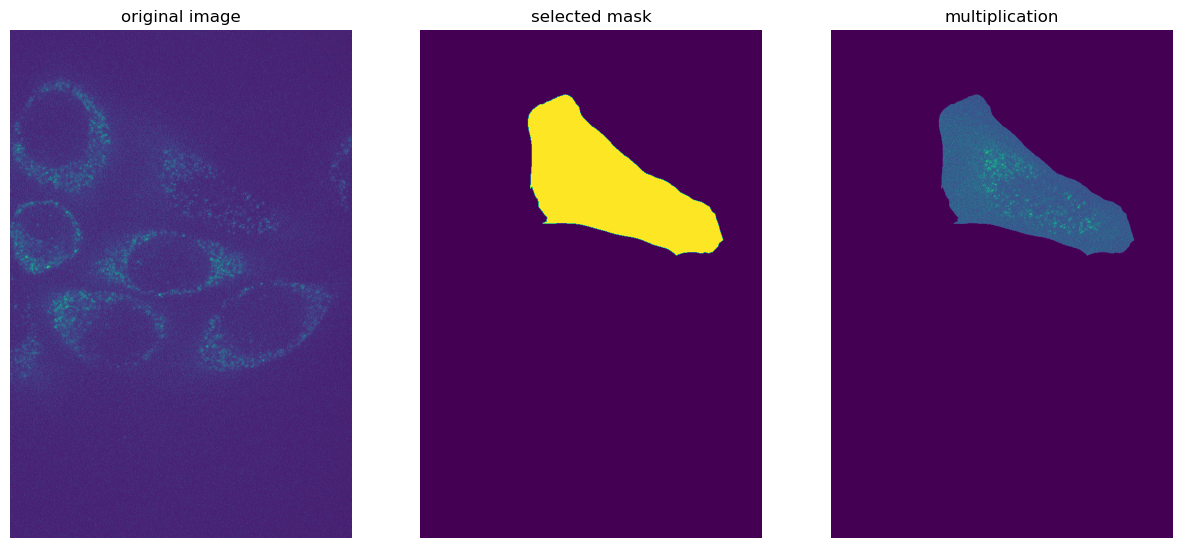

In [26]:
# Here is how we can select the pixels forming a cell, by multiplying the mask by the image
fig, ax = plt.subplots(1,3, figsize=(15, 8))

# show original image
ax[0].imshow(img_cyto[:,:,2])
ax[0].set(title='original image')

# select a mask
selected_cell_label = 2
selected_mask = masks_cyto == selected_cell_label  # Select other cell label

# show the mask
ax[1].imshow(selected_mask)
ax[1].set(title='selected mask')

# multiply the mask by the image and show that
ax[2].imshow(selected_mask*img_cyto[:,:,2])
ax[2].set(title='multiplication')

for i in range(len(ax)):
    ax[i].axis('off')

plt.show()

In [31]:
# Let' compute the mean intensity for each cell in the image.
list_mean_intensities = []
for iMask in range (1,number_detected_cells+1):
  selected_mask = masks_cyto==iMask
  mean_intensity = []
  for iColor in range(3):
    selected_color_image = selected_mask*img_cyto[:,:,iColor]
    mean_intensity.append(selected_color_image[np.nonzero(selected_color_image)].mean())
  list_mean_intensities.append(mean_intensity)

# Convert the list to a pandas dataframe and display
import pandas as pd
df = pd.DataFrame(list_mean_intensities, columns=['Ch0', 'Ch1', 'Ch2'])
df

Ch0         Ch1         Ch2
0  698.058159  659.403869  759.201131
1  576.353581  570.380991  676.313206
2  564.586672  559.083072  621.238508
3  742.239695  569.632778  812.385037
4  669.372830  690.734059  771.902838
5  597.595072  598.152482  703.891728
6  704.699753  665.014432  712.268991
7  677.217613  671.296833  774.120535

# Spot detection

___

## Spot detection: filtering -> thresholding -> binarization -> labeling

/var/folders/gs/29wgt2xj1jj873ytknj55rsr0000gp/T/ipykernel_2764/2674694087.py:23: RuntimeWarning: divide by zero encountered in log10
  ax[1,1].plot(survival, np.log10(np.arange(len(survival))))


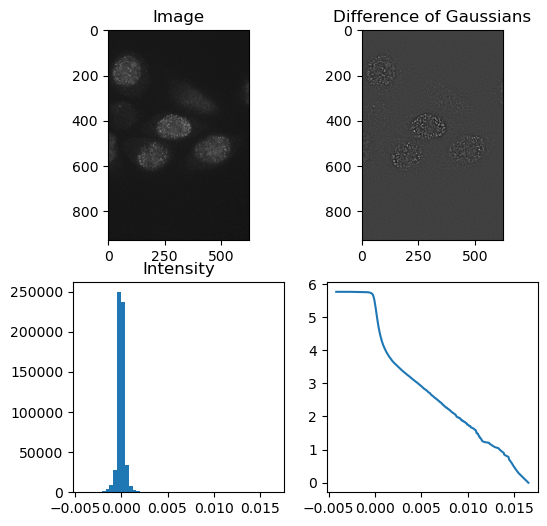

intensity range:  -0.004176958905956665 0.016580984698187026


In [137]:
# Selecting the color channel with RNA spots
zSlice = 10
iChannel = 1
img_spots = images_FISH[zSlice,:,:,iChannel]

# Show the original image
fig, ax = plt.subplots(2,2, figsize=(6, 6))
ax[0,0].imshow(img_spots,cmap='Greys_r')
ax[0,0].set(title='Image')

# Apply a difference of Gaussians filter to the image to enhance spots
img_spots_filtered = difference_of_gaussians(img_spots,low_sigma=1, high_sigma=5)
ax[0,1].imshow(img_spots_filtered,cmap='Greys_r')
ax[0,1].set(title= 'Difference of Gaussians' )

# Make a histogram of the intensity values
ax[1,0].hist(img_spots_filtered.flatten(),bins=50)
ax[1,0].set(title= 'Intensity' )

# Make a survival plot of the intensity values
survival = np.sort(img_spots_filtered.flatten())
survival = survival[::-1]
ax[1,1].plot(survival, np.log10(np.arange(len(survival))))

plt.show()
print('intensity range: ', np.min(img_spots_filtered), np.max(img_spots_filtered))

In [216]:
threshold = 0.0055

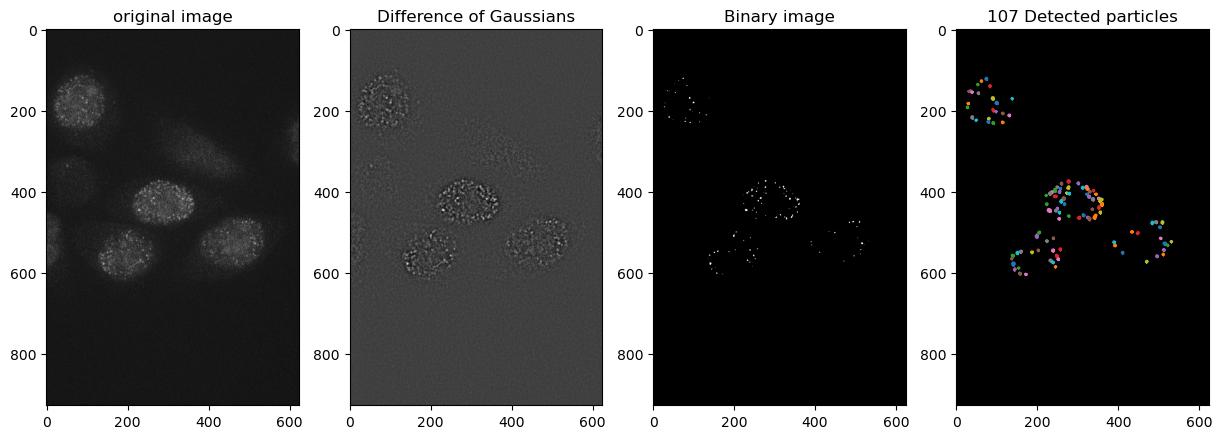

In [217]:
# Show original image in MS2 channel
fig, ax = plt.subplots(1,4, figsize=(15, 6))
ax[0].imshow(img_spots,cmap='Greys_r')
ax[0].set(title='original image')

# Apply a difference of Gaussians filter to the image to enhance spots
ax[1].imshow(img_spots_filtered,cmap='Greys_r')
ax[1].set(title= 'Difference of Gaussians' )

# Apply a Threshold to the image to create binary image
img_spots_binary = img_spots_filtered.copy()
img_spots_binary[img_spots_binary>=threshold] = threshold # Making spots above the threshold equal to the threshold value.
img_spots_binary[img_spots_binary<threshold] = 0 # Making spots below the threshold equal to 0.
ax[2].imshow(img_spots_binary,cmap='Greys_r')
ax[2].set(title= 'Binary image' )

# Image binarization
img_spots_binary[img_spots_binary!=0] = 1 # Binarization
ax[3].imshow(img_spots_binary, cmap=plt.cm.gray)

# Labeling. Joining pixels in "particles"
spot_contours = measure.find_contours(img_spots_binary, 0.5)
for contour in spot_contours:
    ax[3].plot(contour[:, 1], contour[:, 0], linewidth=2)
ax[3].set(title= str(len(spot_contours))+' Detected particles' )
plt.show()

In [139]:
# Counting the detected particles in each cell

list_cytosol_particles = np.zeros(number_detected_cells)
list_nuclear_particles = np.zeros(number_detected_cells)

# Loop through the cytosol masks
for i in range(len(spot_contours)):
    # Find the position of the particle
    posn = np.mean(spot_contours[i], axis=0).astype(int)

    # Check which cyto mask is the particle in
    cell_num = masks_cyto[posn[0], posn[1]]
    if cell_num>0:
        list_cytosol_particles[cell_num-1] += 1

        # Check if the particle is also in the nucleus
        if masks_nuc[posn[0], posn[1]] == nucleus_indices[cell_num]:
            list_nuclear_particles[cell_num-1] += 1

# Add the number of particles to the dataframe
df['Particles in cytosol'] = list_cytosol_particles
df['Particles in nucleus'] = list_nuclear_particles
df

Ch0         Ch1         Ch2  Particles in cytosol  \
0  698.058159  659.403869  759.201131                  29.0   
1  576.353581  570.380991  676.313206                   0.0   
2  564.586672  559.083072  621.238508                   0.0   
3  742.239695  569.632778  812.385037                   0.0   
4  669.372830  690.734059  771.902838                  50.0   
5  597.595072  598.152482  703.891728                   0.0   
6  704.699753  665.014432  712.268991                  20.0   
7  677.217613  671.296833  774.120535                  28.0   

   Particles in nucleus  
0                  29.0  
1                   0.0  
2                   0.0  
3                   0.0  
4                  50.0  
5                   0.0  
6                  20.0  
7                  28.0

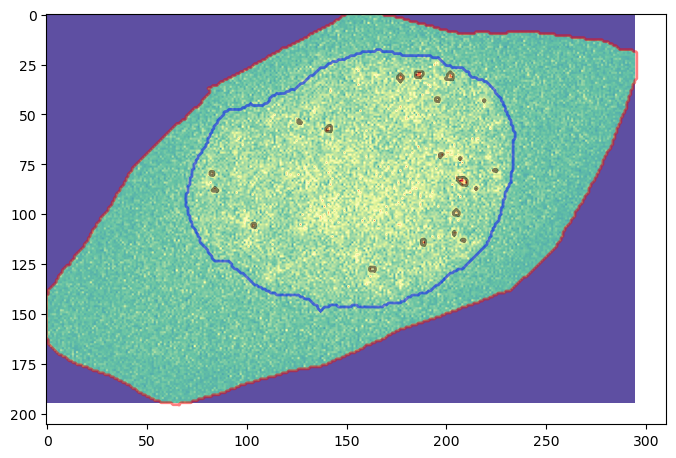

In [141]:
# Let's now look at individual cells in the image

cell_num = 7 # Choose which cell to look at
selected_cyto_mask = masks_cyto==cell_num
selected_nuc_mask = masks_nuc==nucleus_indices[cell_num]

# Crop the original image to show just the selected cell
image_cropped = img_cyto.copy()
image_cropped[~selected_cyto_mask] = 0

# remove rows and columns that are all zeros
rows = np.any(image_cropped[:,:,0], axis=1)
rlims = [np.min(np.where(rows)), np.max(np.where(rows))]
cols = np.any(image_cropped[:,:,0,], axis=0)
clims = [np.min(np.where(cols)), np.max(np.where(cols))]
image_cropped = image_cropped[rlims[0]:rlims[1], clims[0]:clims[1], :]

# display the cropped image
fig, ax = plt.subplots(1,1, figsize=(8, 8))
ax.imshow(image_cropped[:,:,1],cmap='Spectral_r')

# draw the contours of the cytosol and nucleus
cyto_contours = measure.find_contours(selected_cyto_mask, 0.5)
nuc_contours = measure.find_contours(selected_nuc_mask, 0.5)
for contour in cyto_contours:
    ax.plot(contour[:, 1]-clims[0], contour[:, 0]-rlims[0], linewidth=2, color='r', alpha=0.5)
for contour in nuc_contours:
    ax.plot(contour[:, 1]-clims[0], contour[:, 0]-rlims[0], linewidth=2, color='b', alpha=0.5)

# Add the contours of the particles to the image
for contour in spot_contours:
    # Check if the particle is in the selected cell
    posn = np.mean(contour, axis=0).astype(int)
    if selected_cyto_mask[posn[0], posn[1]]:
        ax.plot(contour[:, 1]-clims[0], contour[:, 0]-rlims[0], linewidth=2, color='k', alpha=0.5)


![alt text](FigsA/Module_1_3/Slide8.png)

In [62]:
# Installing libraries
%pip install trackpy
import trackpy as tp # Library for particle tracking

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 kB 1.2 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for trackpy: filename=trackpy-0.6.2-py3-none-any.whl size=130035 sha256=d4df25f0937a1081fd207fbfc7a55ce9a9948162d7abd9941562783862cb49de
  Stored in directory: /Users/munsky/Library/Caches/pip/wheels/46/c1/64/60f8d79891e534b95d868d744e32c731634b1f98b0a77601ba
Successfully built trackpy
Note: you may need to restart the kernel to use updated packages.


In [165]:
# This section generates an histograme with the intensity of the detected particles in the image.
particle_size = 5 # according to the documentation must be an odd number 3,5,7,9 etc.
minimal_intensity_for_selection = 0 # minimal intensity to detect a particle.
# "spots_detected_dataframe" is a pandas data freame that contains the infomation about the detected spots
spots_detected_dataframe = tp.locate(img_spots, diameter=particle_size, minmass=minimal_intensity_for_selection)


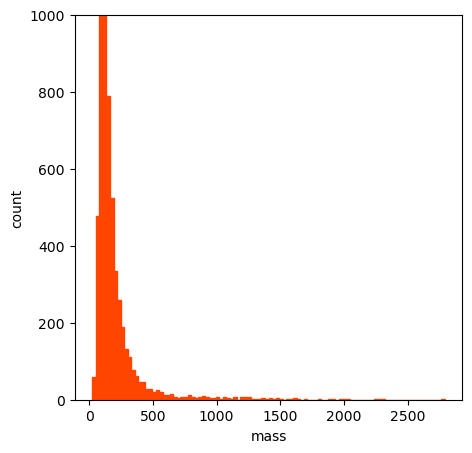

In [166]:
fig, ax = plt.subplots(1,1, figsize=(5, 5))
ax.hist(spots_detected_dataframe['mass'], bins=100, color = "orangered", ec="orangered")
ax.set(xlabel='mass', ylabel='count')
ax.set_ylim([0,1000])
plt.show()

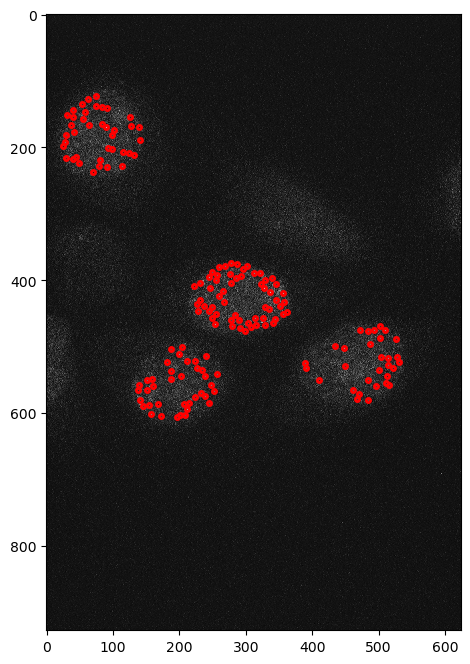

In [172]:
fig, ax = plt.subplots(1,1, figsize=(8, 8))
spots_detected_dataframe = tp.locate(img_spots,diameter=5, minmass=700) # "spots_detected_dataframe" is a pandas data freame that contains the infomation about the detected spots
tp.annotate(spots_detected_dataframe,img_spots,plot_style={'markersize': 3})  # tp.anotate is a trackpy function that displays the image with the detected spots
ax.axis('off')
plt.show()

In [145]:
spots_detected_dataframe.head()

y           x        mass      size       ecc     signal  \
1590  135.678426   85.000000  161.726074  0.648056  0.381085  93.804900   
1649  140.366861   73.861051  168.503230  0.711203  0.526439  83.272630   
1657  140.893112  116.000000  213.027878  0.778844  0.351462  83.805602   
1756  147.957171   55.000000  177.973297  0.782926  0.368606  68.880523   
1923  160.022527   69.000000  179.727429  0.773796  0.329881  72.113885   

      raw_mass        ep  
1590    3960.0  0.283264  
1649    3652.0  0.392082  
1657    3869.0  0.308567  
1756    4418.0  0.200512  
1923    4380.0  0.205493

In [73]:
help(tp.locate)

Help on function locate in module trackpy.feature:

locate(raw_image, diameter, minmass=None, maxsize=None, separation=None, noise_size=1, smoothing_size=None, threshold=None, invert=False, percentile=64, topn=None, preprocess=True, max_iterations=10, filter_before=None, filter_after=None, characterize=True, engine='auto')
    Locate Gaussian-like blobs of some approximate size in an image.
    
    Preprocess the image by performing a band pass and a threshold.
    Locate all peaks of brightness, characterize the neighborhoods of the peaks
    and take only those with given total brightness ("mass"). Finally,
    refine the positions of each peak.
    
    Parameters
    ----------
    raw_image : array (any dimensions)
        Image used for final characterization. Ideally, pixel values of
        this image are not rescaled, but it can also be identical to
        ``image``.
    image : array (same size as raw_image)
        Processed image used for centroid-finding and most particl

## Extracting information from a Pandas data frame using conditionals

In [74]:
# Showing information for particle with mass larger than >
min_mass = 200
spots_detected_dataframe.loc[spots_detected_dataframe['mass']>min_mass ]

y           x        mass      size       ecc      signal  \
1657  140.893112  116.000000  213.027878  0.778844  0.351462   83.805602   
2546  205.950328   63.000000  222.952374  0.714773  0.042670  109.046023   
2769  221.982845  104.000000  214.965278  0.692557  0.084920  111.860488   
5128  388.895376  318.000000  231.614567  0.788892  0.393189   87.469082   
5300  401.002463  270.000000  208.059086  0.727429  0.110188   97.963950   
5315  402.138355  256.039757  216.751201  0.659227  0.484038  122.555454   
5373  406.145545  229.000000  203.357714  0.752112  0.232195   88.323706   
5510  415.942175  348.947959  212.767938  0.733503  0.052096   98.293084   
5562  419.979816  351.948729  308.429824  0.805139  0.438358  108.490610   
5586  421.774509  256.000000  206.546194  0.730355  0.125299   96.370645   
5643  426.176575  335.000000  228.083863  0.756209  0.251298   97.653517   
6952  520.049249  512.088347  207.821586  0.730110  0.207431   97.040132   
7542  560.862249  138.000000  215.434667  0.766148  0.296372   88.978233   

      raw_mass        ep  
1657    3869.0  0.308567  
2546    3785.0  0.336295  
2769    4068.0  0.258142  
5128    5356.0  0.125453  
5300    5080.0  0.140982  
5315    5822.0  0.105781  
5373    5018.0  0.145014  
5510    4792.0  0.161892  
5562    4804.0  0.160898  
5586    3899.0  0.299740  
5643    5574.0  0.115412  
6952    4042.0  0.263774  
7542    4364.0  0.207665

In [75]:
# Showing information for particles smaller than a given size
min_size = 0.55
spots_detected_dataframe.loc[spots_detected_dataframe['size']<min_size]

y          x        mass     size      ecc      signal  raw_mass  \
2666  215.0  37.189735  152.308369  0.54906  3.31711  106.392384    5465.0   

            ep  
2666  0.120223

In [76]:
# Extracting the y values for all particles
spots_detected_dataframe.y.values[0:10]

array([135.67842648, 140.36686088, 140.89311235, 147.95717093,
       154.35867885, 153.96942617, 160.02252698, 160.98444608,
       169.01511506, 173.13015422])

In [77]:
# Save the particles trajectories and intensities as a CSV file
spots_detected_dataframe.to_csv(r'./detected_spots.csv', index = False)

In [78]:
def spots_in_mask(df,masks):
    # extracting the contours in the image
    coords = np.array([df.y, df.x]).T # These are the points detected by trackpy
    coords_int = np.round(coords).astype(int)  # or np.floor, depends
    values_at_coords = masks[tuple(coords_int.T)] # If 1 the value is in the mask
    df['In Mask']=values_at_coords # Check if pts are on/in polygon mask
    return df

In [79]:
dataframe_spots_in_nuc = spots_in_mask(df=spots_detected_dataframe, masks= masks_nuc)

In [80]:
dataframe_spots_in_nuc

y           x        mass      size       ecc      signal  \
1590  135.678426   85.000000  161.726074  0.648056  0.381085   93.804900   
1649  140.366861   73.861051  168.503230  0.711203  0.526439   83.272630   
1657  140.893112  116.000000  213.027878  0.778844  0.351462   83.805602   
1756  147.957171   55.000000  177.973297  0.782926  0.368606   68.880523   
1843  154.358679   36.000000  157.232280  0.598898  0.788009  100.836387   
...          ...         ...         ...       ...       ...         ...   
7471  556.162458  479.000000  196.563726  0.764123  0.287330   81.793400   
7505  557.992704  493.000000  177.879793  0.718511  0.062986   86.047824   
7542  560.862249  138.000000  215.434667  0.766148  0.296372   88.978233   
7580  564.075567  438.000000  160.263674  0.749831  0.221422   70.155915   
7681  571.005667  236.726849  150.468214  0.798452  0.425472   54.540777   

      raw_mass        ep  In Mask  
1590    3960.0  0.283264        1  
1649    3652.0  0.392082        1  
1657    3869.0  0.308567        1  
1756    4418.0  0.200512        1  
1843    4580.0  0.181733        1  
...        ...       ...      ...  
7471    4044.0  0.263332        7  
7505    4203.0  0.232381        7  
7542    4364.0  0.207665        8  
7580    3787.0  0.335577        7  
7681    3781.0  0.337740        8  

[99 rows x 9 columns]

In [85]:
# Extracting only the spots located on a given cell
selected_cell = 1 # Test cell 1
dataframe_spots_cell_N = dataframe_spots_in_nuc[dataframe_spots_in_nuc['In Mask']==selected_cell]
dataframe_spots_cell_N

y           x        mass      size       ecc      signal  \
1590  135.678426   85.000000  161.726074  0.648056  0.381085   93.804900   
1649  140.366861   73.861051  168.503230  0.711203  0.526439   83.272630   
1657  140.893112  116.000000  213.027878  0.778844  0.351462   83.805602   
1756  147.957171   55.000000  177.973297  0.782926  0.368606   68.880523   
1843  154.358679   36.000000  157.232280  0.598898  0.788009  100.836387   
1847  153.969426  123.000000  156.951769  0.772881  0.325927   63.197361   
1923  160.022527   69.000000  179.727429  0.773796  0.329881   72.113885   
1942  160.984446   62.000000  190.327022  0.788140  0.390120   72.102664   
2051  169.015115   36.000000  154.653445  0.591336  0.859776  100.574577   
2111  173.130154  104.000000  159.098616  0.698216  0.051260   81.537199   
2136  175.097843   99.000000  194.398178  0.760989  0.273194   81.821451   
2356  191.870788   75.000000  187.048778  0.770746  0.316638   75.932581   
2384  193.823018   80.000000  196.842368  0.770092  0.313779   80.106591   
2496  202.820646   94.851320  154.670276  0.804069  0.006658   54.671682   
2528  204.784330  118.000000  154.309351  0.750657  0.225331   67.358280   
2546  205.950328   63.000000  222.952374  0.714773  0.042670  109.046023   
2666  215.000000   37.189735  152.308369  0.549060  3.317110  106.392384   
2769  221.982845  104.000000  214.965278  0.692557  0.084920  111.860488   

      raw_mass        ep  In Mask  
1590    3960.0  0.283264        1  
1649    3652.0  0.392082        1  
1657    3869.0  0.308567        1  
1756    4418.0  0.200512        1  
1843    4580.0  0.181733        1  
1847    4001.0  0.273172        1  
1923    4380.0  0.205493        1  
1942    4750.0  0.165471        1  
2051    4668.0  0.172936        1  
2111    4301.0  0.216683        1  
2136    5336.0  0.126462        1  
2356    4535.0  0.186588        1  
2384    3454.0  0.520663        1  
2496    4820.0  0.159591        1  
2528    4077.0  0.256248        1  
2546    3785.0  0.336295        1  
2666    5465.0  0.120223        1  
2769    4068.0  0.258142        1

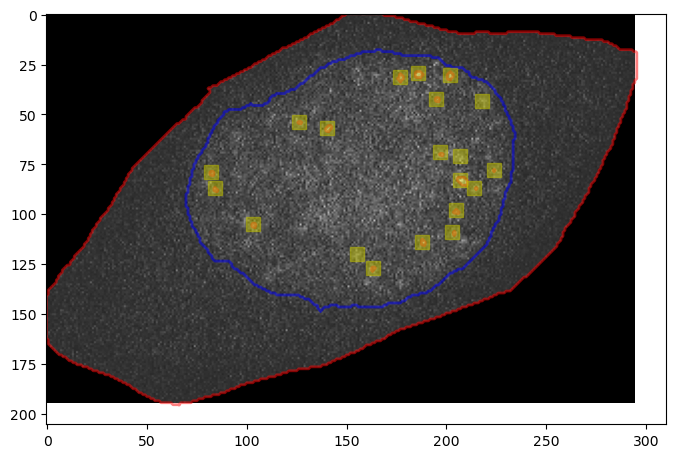

In [218]:
# Let's now look at individual cells in the image
# We will plot the detected spots of the selected cell using both particle finding approaches
img_spots_filtered_thresholded = img_spots_filtered.copy()
img_spots_filtered_thresholded[img_spots_filtered_thresholded<=0] = 0
img_spots_filtered_thresholded = 255*img_spots_filtered_thresholded/np.max(img_spots_filtered_thresholded)
spots_detected_dataframe = tp.locate(img_spots_filtered_thresholded, diameter=5, minmass=110) # "spots_detected_dataframe" is a pandas data freame that contains the infomation about the detected spots

cell_num = 7 # Choose which cell to look at
selected_cyto_mask = masks_cyto==cell_num
selected_nuc_mask = masks_nuc==nucleus_indices[cell_num]

# Crop the original image to show just the selected cell
image_cropped = img_cyto.copy()
image_cropped[~selected_cyto_mask] = 0

# remove rows and columns that are all zeros
rows = np.any(image_cropped[:,:,0], axis=1)
rlims = [np.min(np.where(rows)), np.max(np.where(rows))]
cols = np.any(image_cropped[:,:,0,], axis=0)
clims = [np.min(np.where(cols)), np.max(np.where(cols))]
image_cropped = image_cropped[rlims[0]:rlims[1], clims[0]:clims[1], :]

# display the cropped image
fig, ax = plt.subplots(1,1, figsize=(8, 8))
ax.imshow(image_cropped[:,:,1],cmap='gray')

# draw the contours of the cytosol and nucleus
cyto_contours = measure.find_contours(selected_cyto_mask, 0.5)
nuc_contours = measure.find_contours(selected_nuc_mask, 0.5)
for contour in cyto_contours:
    ax.plot(contour[:, 1]-clims[0], contour[:, 0]-rlims[0], linewidth=2, color='r', alpha=0.5)
for contour in nuc_contours:
    ax.plot(contour[:, 1]-clims[0], contour[:, 0]-rlims[0], linewidth=2, color='b', alpha=0.5)

# Add the contours where our first approach found particles in the image
for contour in spot_contours:
    # Check if the particle is in the selected cell
    posn = np.mean(contour, axis=0).astype(int)
    if selected_cyto_mask[posn[0], posn[1]]:
        ax.plot(contour[:, 1]-clims[0], contour[:, 0]-rlims[0], linewidth=2, color='r', alpha=0.5)

# Add red 'x' markers where trackpy found particles to the image
for i in range(len(spots_detected_dataframe)):
    # Check if the particle is in the selected cell
    posn = np.array([spots_detected_dataframe.y.values[i], spots_detected_dataframe.x.values[i]]).astype(int)
    if selected_cyto_mask[posn[0], posn[1]]:
        ax.plot(posn[1]-clims[0], posn[0]-rlims[0], 's', color='y', alpha=0.5, markersize=10)


In [219]:
# Lets now look at the detected spots individually to see which are found with both methods

# Create a matrix showing the distance between the spots detected by trackpy and the spots detected by the mask
dist_matrix = np.zeros((len(spots_detected_dataframe), len(spot_contours)))
for i in range(len(spots_detected_dataframe)):
    for j in range(len(spot_contours)):
        dist_matrix[i,j] = np.linalg.norm(np.array([spots_detected_dataframe.y.values[i], spots_detected_dataframe.x.values[i]]) - np.mean(spot_contours[j], axis=0))

maxDist = 10
indexList = []
while np.min(dist_matrix) < maxDist:
    # Find the shortest distance in the matrix and record the indexes
    indexes = np.unravel_index(np.argmin(dist_matrix, axis=None), dist_matrix.shape)
    indexList.append(indexes)

    # Set all entries in the row and column of the minimum distance to infinity
    dist_matrix[indexes[0],:] = np.inf
    dist_matrix[:,indexes[1]] = np.inf

print('Number of matches: ', len(indexList))
print('Number TrackPy Leftover: ', len(spots_detected_dataframe)-len(indexList))
print('Number Mask Leftover: ', len(spot_contours)-len(indexList))


Number of matches:  101
Number TrackPy Leftover:  16
Number Mask Leftover:  6


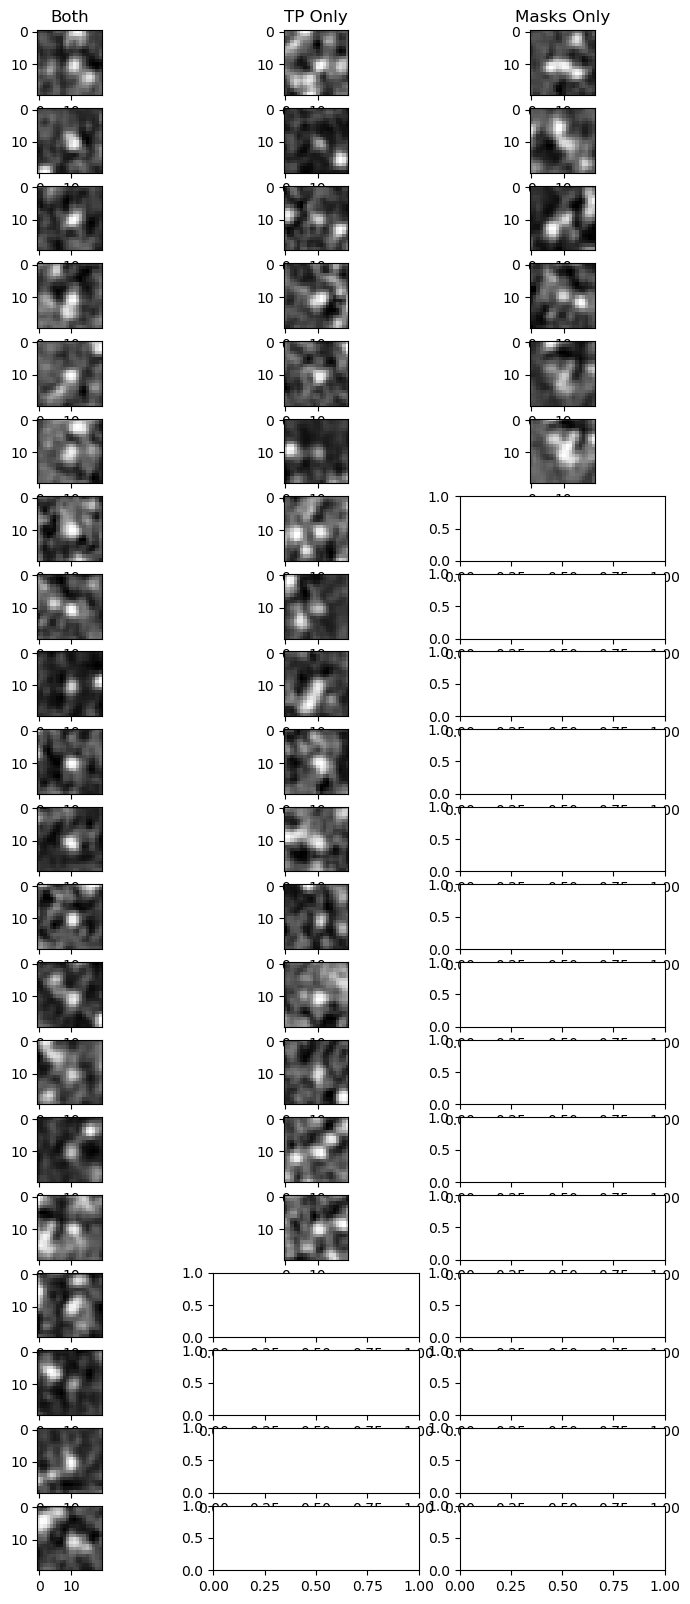

In [220]:
# Now let's look at the individual spots to see if we can determine which approach is better

# Create figure with three columns of 20 images
fig, ax = plt.subplots(20,3, figsize=(9, 20))

img_to_show = img_spots_filtered

# Loop through the first 20 matches, and make a plot for each
for i in range(20):
    # Plot the image
    posn = np.array([spots_detected_dataframe.y.values[indexList[i][0]], spots_detected_dataframe.x.values[indexList[i][0]]]).astype(int)
    ax[i,0].imshow(img_to_show[posn[0]-10:posn[0]+10,posn[1]-10:posn[1]+10],cmap='Greys_r')
    if i ==0:
        ax[i,0].set(title='Both')

# Loop through the first 20 spots detected onl by trackpy
trackPyLeftover = np.setdiff1d(np.arange(len(spots_detected_dataframe)), np.array(indexList)[:,0])
for j in range(min(20,len(trackPyLeftover))):
    i = trackPyLeftover[j]
    posn = np.array([spots_detected_dataframe.y.values[i], spots_detected_dataframe.x.values[i]]).astype(int)
    ax[j,1].imshow(img_to_show[posn[0]-10:posn[0]+10,posn[1]-10:posn[1]+10],cmap='Greys_r')
    if j ==0:
        ax[j,1].set(title='TP Only')

# Loop through the first 20 spots detected only by the mask
maskLeftover = np.setdiff1d(np.arange(len(spot_contours)), np.array(indexList)[:,1])
for j in range(min(20,len(maskLeftover))):
    i = maskLeftover[j]
    posn = np.mean(spot_contours[i], axis=0).astype(int)
    ax[j,2].imshow(img_to_show[posn[0]-10:posn[0]+10,posn[1]-10:posn[1]+10],cmap='Greys_r')
    if j ==0:
        ax[j,2].set(title='Masks Only')


- Spot detection using [Big-FISH](https://github.com/fish-quant/big-fish)
- Spot detection using [FISH Processing](https://colab.research.google.com/drive/1CQx4e5MQ0ZsZSQgqtLzVVh53dAg4uaQj?usp=sharing)

# References

*  Image downloaded from https://figshare.com from publication: "Forero-Quintero, Linda, William Raymond, Tetsuya Handa, Matthew Saxton, Tatsuya Morisaki, Hiroshi Kimura, Edouard Bertrand, Brian Munsky, and Timothy Stasevich. "Live-cell imaging reveals the spatiotemporal organization of endogenous RNA polymerase II phosphorylation at a single gene." (2020)."

* "Fox, Z.R., Fletcher, S., Fraisse, A., Aditya, C., Sosa-Carrillo, S., Gilles, S., Bertaux, F., Ruess, J. and Batt, G., 2021. MicroMator: Open and Flexible Software for Reactive Microscopy. bioRxiv. (2021)"